# In this notebook, I used deep learning neural net and python library fast.ai to perform NLP sentiment analysis on IMDB movie reviews

In [1]:
import glob
import numpy as np
import pandas as pd
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *

# Download the IMDB movie reviews datasets from URL

In [11]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/Users/angelali/.fastai/data/imdb/.DS_Store'),
 PosixPath('/Users/angelali/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/Users/angelali/.fastai/data/imdb/README'),
 PosixPath('/Users/angelali/.fastai/data/imdb/test'),
 PosixPath('/Users/angelali/.fastai/data/imdb/tmp_clas'),
 PosixPath('/Users/angelali/.fastai/data/imdb/tmp_lm'),
 PosixPath('/Users/angelali/.fastai/data/imdb/train'),
 PosixPath('/Users/angelali/.fastai/data/imdb/unsup')]

# Preprocess the data

In [10]:
# set databunch size to 20
bs = 20

load the raw data and my vocab file from different folders

In [19]:
data_lm = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))


In [22]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [23]:
data_lm.show_batch()

idx,text
0,"original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in"
1,"obvious . xxmaj avoid like xxmaj ebola crossed with plague . xxbos i have just recently seen xxmaj heaven 's xxmaj gate . xxmaj after i watched this 3 hr 40 min epic western that 's not a western , i read the book by xxmaj steven xxmaj bach . xxmaj after considering all events and the movie itself , i still think this movie is a complete waste of"
2,"on xxmaj zeffirelli 's part to omit that scene . xxmaj it also misplaced a lot of lines ( and cut others that i think should 've been put in ) , such as the line where xxmaj hamlet says to xxmaj ophelia "" xxmaj get thee to a nunnery , why xxunk thou be a breeder of sinners ? "" ; that line was supposed to have occurred in"
3,"movie . \n\n i have a lot of respect to other horror fans who can switch their brains off long enough to enjoy this crap , xxmaj they are more brain dead than i ever will be and that is some achievement ! 0 / 10 and that s generous . xxbos xxmaj as a xxmaj canadian xxmaj history major , my first thing to say : xxup historical xxup"
4,of this garbage . xxmaj the direction is amateurish with annoying cuts and jerky movement that hides the fact that the killer is no where near the victims when he attacks . xxmaj and what a killer he is : a cheap skull mask and a black hood . i liked him better when he was fighting xxmaj he - xxmaj man . xxmaj this is one of the laziest


# Instantiate a language model with the pre-trained language model Wikitext103 and my data

In [25]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


# Find a learning rate that minimize the loss function

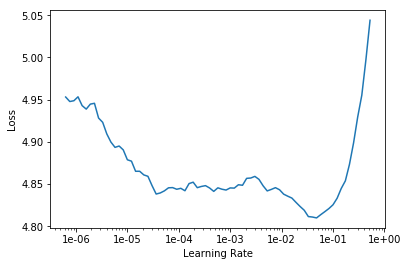

In [28]:
learn.recorder.plot(skip_end=15)

as we can see from above graph, the loss function is minimized when the learning rate is about 1e-2

# Apply transfer learning to fine-tuning the language model 

In [29]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.325061,4.194555,0.284973,9:18:32


In [30]:
learn.save('fit_head')

In [31]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very hi

In [32]:
learn.unfreeze()

In [33]:
learn.save('fine_tuned')

In [34]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very hi

In [37]:
learn.save_encoder('fine_tuned_enc')

preproccessing the data again, eg: remove stop words and punctuation, and stemming words

In [ ]:
path = untar_data(URLs.IMDB)

In [39]:
bs2 = 10

In [45]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs2)

In [46]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxrep 6 * xxup warning : xxup may xxup contain xxup spoilers xxrep 14 * \n\n xxmaj so who are these "" xxmaj mystery xxmaj men ? "" xxmaj simply put , the xxmaj mystery xxmaj men are a group of sub - xxmaj heroes desperately trying to live out their adolescent fantasy lives while botching both their real identities and their super identities . xxmaj the xxmaj shoveller",pos
"xxbos xxmaj for those of you who 've never heard of it ( or seen it on xxup a&e ) , xxmaj cracker is a brilliant xxmaj british xxup tv show about an overweight , chain - smoking , foulmouthed psychologist named xxmaj fitz who helps the xxmaj manchester police department get into the heads of violent criminals . xxmaj it 's considered to be one of the finest shows",neg
"xxbos xxmaj well , it turned out as i expected : visual overload but nothing else added to the original . xxmaj what did surprise me however was that the storyline was fairly drastically changed compared to the 1968 flick . xxmaj initially this awoke my interest , but what eventually surprised was that the new twists and turns ( a ) were apparently invented in order to present us",neg
"xxbos xxmaj reviewing xxup kazaam and saying it 's a bad movie is n't hard at all -- after all , critics at the time it came out fell all over themselves xxunk this film -- saying it was among the worst films of the decade ! xxmaj so the fact that i say it 's bad or anyone else says it 's bad is certainly no surprise . xxmaj",neg


# Build my language classifier on top of my language model

In [48]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

# Find a learning rate that minimize the loss function

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


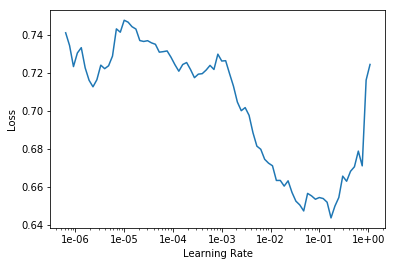

In [50]:
learn.recorder.plot()

# Feed the first databunch to the neural net and backpropagate ( 1 epoch)

In [51]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.496856,0.351140,0.856440,3:43:03


In [52]:
learn.save('first')

In [53]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 

 xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 

 xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker ) to 

# Feed the second databunch to the neural net 
# freeze all the hidden layers except last two layers
# backpropagate to second last layer ( 1 epoch)

In [54]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.412281,0.291428,0.891720,5:19:53


In [55]:
learn.save('second')

In [56]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 

 xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 

 xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker ) to 

# Feed the third databunch to the neural net 
# freeze all the hidden layers expect last 3 layers
# backpropagate to third last layer ( 1 epoch)

In [57]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.332247,0.210037,0.919680,13:12:10


In [58]:
learn.save('third')

In [59]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 

 xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 

 xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker ) to 

# Right now, the model accuracy is about 92%, and i am happy with it, so i try to use it to make prediction

In [60]:
learn.predict("I dont like the movie")

(Category neg, tensor(0), tensor([0.5272, 0.4728]))

In [63]:
learn.predict("the movie is boring, too long")

(Category neg, tensor(0), tensor([9.9998e-01, 2.4848e-05]))

In [68]:
type(learn)

fastai.text.learner.RNNLearner

# Export and save my model, so next time i can just load and use it without running previous code

In [4]:
from sklearn.externals import joblib

In [69]:
filename = 'my_language_classifer.sav'
joblib.dump(learn, filename)

['my_language_classifer.sav']

In [5]:
my_language_classifier = joblib.load('my_language_classifer.sav')

the input of my model is any english sentence that related to movie review, then the model will classify the sentiment of the sentence as either positive or negative with propobility, the following are couple samples

try a sentence with misspelled words and punctuation

In [4]:
my_language_classifier.predict("what a great movie, i enjoyedsds a lot, but just a bit too long")

(Category pos, tensor(1), tensor([0.0028, 0.9972]))

In [10]:
my_language_classifier.predict("this is stupid, really waste my time")

(Category neg, tensor(0), tensor([1.0000e+00, 3.5480e-10]))

try a vague sentence 

In [11]:
my_language_classifier.predict("i love the movie, bad actors, but great plot")

(Category pos, tensor(1), tensor([4.3552e-04, 9.9956e-01]))